### 주제 :  네이버 영화 리뷰 감정 분석 

#### - 프로젝트 목적 :  수많은 정보의 바다에서 빠르게 정보의 감정을 분별하기 위함 

#### - 가설 : 텍스트를 학습하여 글감정을 분류할 수 있다. 

#### - 활용 방안  :  사람들이 남기는 댓글,평가에서 사람들의 반응을 빠르게 알아 볼 수 있다. 반응을 보고 개선 할지 이대로 가면될지 등을 결정 할 수 있다. 



In [8]:
!pip install matplotlib

In [14]:
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 1.7 MB/s eta 0:00:00a 0:00:01


In [15]:
import matplotlib.pyplot as plt  
import numpy as np 
import pandas as pd

import re
import urllib.request
from konlpy.tag import Okt, Mecab
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2022-10-02 19:27:14.043101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 데이터 가져오기 

In [19]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f9aabbcfd00>)

In [20]:
# 20만개의 네이버 영화 리뷰 데이터 
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')
len(train_data) , len(test_data)

(150000, 50000)

In [21]:
train_data[:5] 

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 전처리 

In [22]:
# 중복 체크  
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [23]:
# 중복 제거 
train_data.drop_duplicates(subset=['document'], inplace=True)

In [24]:
len(train_data)

146183

<AxesSubplot: >

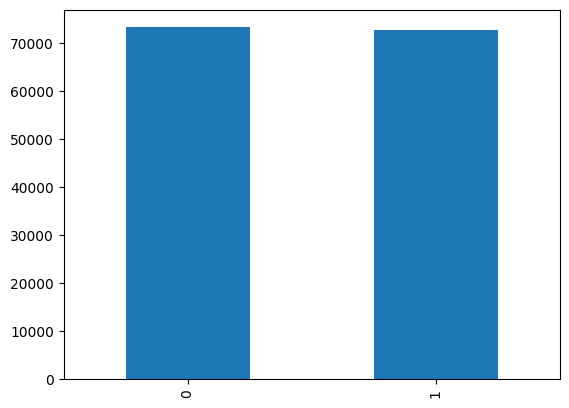

In [25]:
# 데이터 비율 반반 
train_data['label'].value_counts().plot(kind = 'bar')

In [27]:
# null check :  1개 
train_data.isnull().values.any(), train_data.isnull().sum()

(True,
 id          0
 document    1
 label       0
 dtype: int64)

In [28]:
# null remove  
train_data.dropna(subset="document", inplace=True)
len(train_data)

146182

In [31]:
# null check : 없음 
train_data.isnull().values.any()

False

In [32]:
# 한글 띄어쓰기 뺴고 전부 제거 
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

/var/folders/t9/bq0w6zc57lggtvdfc84ssq800000gn/T/ipykernel_98669/2092559641.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [227]:
#공백만 남는 열 nan 처리하고 지워주기 
# train_data["document"] = train_data['document'].str.replace('', np.nan)
train_data["document"] = train_data['document'].replace(' ', np.nan)

In [231]:
train_data["document"].isnull().sum()

0

In [229]:

train_data.dropna(subset="document", inplace= True)

In [376]:

train_data.sample(20)

,id,document,label
1438,7996509,해병으로 꼭 나와야만 했나요 손자나 그년이나 손자 친구년놈들이나 ㅉㅉ,0
916,39563,좋네괜찮고,1
118881,9790849,평점이 넘 높아서 로긴함,0
16227,8536293,와 이걸 이제야 보다니,1
1529,7194828,마지막 결말이 소름 돌아서 지금도 소름 돌네요,1
101073,10184587,영화를 감히 평가하는 너네 평론가들 때문에 평범한영화가 더 저급해 지는거야 이 사회...,1
58865,8077934,재미재미잼잼 보고말해라,1
84843,8066537,엘렌진짜사랑스럽다,1
116292,8676391,논스톱시청 감정선 쭈욱 이어진 캐릭터도 캐스팅도 스토리도 도 다 좋은 군더더기 없는...,1
10124,8680004,대학 동아리에서 대충 만든 영화 아니 그냥 쓸데없는 동영상 같은 느낌 단역들 대사는...,0


In [341]:
train_data[train_data["document"] ==  ' ']


,id,document,label


In [342]:
train_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [234]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


/var/folders/t9/bq0w6zc57lggtvdfc84ssq800000gn/T/ipykernel_98669/3570305079.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
/var/folders/t9/bq0w6zc57lggtvdfc84ssq800000gn/T/ipykernel_98669/3570305079.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


In [359]:
test_data.sample(20)

,id,document,label
1957,8251773,평점조절 점짜리는 아니지만 볼만했다 점이상은 됨막판에 급전개만 아니였어도 괜찮은 영화임,1
30075,8196890,긴장감도 있고 재미있습니다,1
7604,7447169,의미있는영화 잘봤습니다,1
30482,10015834,점은 됩니다,0
32137,8894572,후제가 궁금한게 있는데요한국판 캐스팅이랑 이거 평점 주는거랑 무슨 상관,1
24886,7517133,서정적인느낌으로 동화를 보는 것같아서 재미있게 보았어요 하지만 이이들은 덜 재미있다...,1
30286,6403671,연장을 넘 마니잡아씀너무질질끌어 잼없슴추적자보고 빛그림자는 이제 다시보기로본다는,0
20909,8624445,평점 많이 내려갔네 더 내려야지,0
34322,5132046,슬퍼잉,1
27186,1101279,관계맺음의 여성적 상처 그럼에도 삶은 계속된다,1


In [285]:
# 불용어 
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [290]:
# 형태소 분리 
mecab= Mecab()

X_train  = []
for senten in train_data["document"] : 
    X_train.append([ words for words in mecab.morphs(senten) if not words in stopwords ])
    

In [291]:
X_train[:2] 

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나']]

In [294]:
# 토큰에 정수 지정
tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)

In [300]:
tokenizer.word_index  # 49946 개 

{'영화': 1,
 '다': 2,
 '고': 3,
 '하': 4,
 '을': 5,
 '보': 6,
 '게': 7,
 '지': 8,
 '있': 9,
 '없': 10,
 '좋': 11,
 '나': 12,
 '었': 13,
 '만': 14,
 '는데': 15,
 '너무': 16,
 '봤': 17,
 '적': 18,
 '안': 19,
 '정말': 20,
 '로': 21,
 '것': 22,
 '음': 23,
 '아': 24,
 '네요': 25,
 '어': 26,
 '재밌': 27,
 '지만': 28,
 '같': 29,
 '진짜': 30,
 '에서': 31,
 '했': 32,
 '기': 33,
 '네': 34,
 '않': 35,
 '점': 36,
 '거': 37,
 '았': 38,
 '수': 39,
 '되': 40,
 '면': 41,
 'ㅋㅋ': 42,
 '인': 43,
 '말': 44,
 '연기': 45,
 '주': 46,
 '최고': 47,
 '내': 48,
 '평점': 49,
 '이런': 50,
 '던': 51,
 '어요': 52,
 '할': 53,
 '왜': 54,
 '겠': 55,
 '스토리': 56,
 '해': 57,
 'ㅋㅋㅋ': 58,
 '습니다': 59,
 '듯': 60,
 '아니': 61,
 '드라마': 62,
 '생각': 63,
 '더': 64,
 '그': 65,
 '싶': 66,
 '사람': 67,
 '때': 68,
 '감동': 69,
 '배우': 70,
 '함': 71,
 '본': 72,
 '까지': 73,
 '뭐': 74,
 '알': 75,
 '만들': 76,
 '내용': 77,
 '볼': 78,
 '보다': 79,
 '감독': 80,
 '라': 81,
 '재미': 82,
 '그냥': 83,
 '시간': 84,
 '지루': 85,
 '중': 86,
 '재미있': 87,
 '였': 88,
 '잼': 89,
 '년': 90,
 '사랑': 91,
 '못': 92,
 '재미없': 93,
 '냐': 94,
 '쓰레기': 95,
 '서': 96,
 '라고'

In [298]:
# 리뷰데이터를  형태소 분해하고 불용어 제거  
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [00:05<00:00, 8605.05it/s]


In [374]:
불용어 = ["대",'한',"민국"]
문장 = ["대","한","민국","만세"]
h = [ i for i in 문장 if i not in 불용어  ]
h

['만세']

In [301]:
i = 0
for key, value in tokenizer.word_counts.items():
    print(key, value) 
    i += 1 
    if i ==10 : 
        break
       

아 8947
더 5128
빙 268
진짜 8301
짜증 1470
나 12530
네요 8930
목소리 368
흠 239
포스터 568


### 빈도가 낮은 단어 제거 

In [303]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 49946
등장 빈도가 2번 이하인 희귀 단어의 수: 28320
단어 집합에서 희귀 단어의 비율: 56.70123733632323
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.7606788534131563


In [304]:
vocab_size = total_cnt - rare_cnt + 1  # 중요하지 않은 단어 삭제 , 0번 패딩 토큰을 위해 + 1 
vocab_size 

21627

In [305]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [306]:
X_train[:3]

[[24, 64, 892, 30, 211, 12, 25, 696],
 [974, 478, 488, 633, 1, 107, 1551, 45, 863, 946, 8, 35, 361],
 [16, 189]]

In [307]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [308]:
# 빈도가 낮은 단어로 이루어진 문장들은 공백이 되었을 수 있기 떄문에 길이가 0인 문장은 삭제 해준다 . 
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [309]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145190
145190


/Users/tjrksp/opt/anaconda3/envs/s3n2/lib/python3.8/site-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰의 최대 길이 : 83
리뷰의 평균 길이 : 13.576107169915284


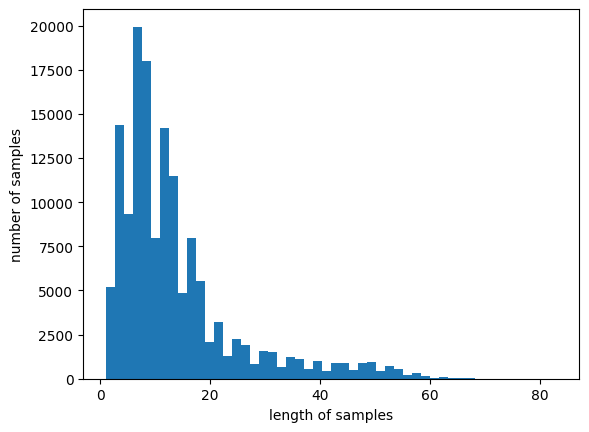

In [310]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [311]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [312]:
max_len = 40
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 95.04924581582753


### 패딩 - 전처리 끝 


In [313]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

### 모델학습

In [314]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

2022-10-04 15:23:17.361527: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/15
1815/1815 [==============================] - ETA: 0s - loss: 0.3872 - acc: 0.8257
Epoch 1: val_acc improved from -inf to 0.84699, saving model to best_model.h5
1815/1815 [==============================] - 123s 66ms/step - loss: 0.3872 - acc: 0.8257 - val_loss: 0.3454 - val_acc: 0.8470
Epoch 2/15
1815/1815 [==============================] - ETA: 0s - loss: 0.3206 - acc: 0.8624
Epoch 2: val_acc improved from 0.84699 to 0.85939, saving model to best_model.h5
1815/1815 [==============================] - 121s 67ms/step - loss: 0.3206 - acc: 0.8624 - val_loss: 0.3237 - val_acc: 0.8594
Epoch 3/15
1814/1815 [============================>.] - ETA: 0s - loss: 0.2934 - acc: 0.8766
Epoch 3: val_acc improved from 0.85939 to 0.86029, saving model to best_model.h5
1815/1815 [==============================] - 118s 65ms/step - loss: 0.2934 - acc: 0.8766 - val_loss: 0.3231 - val_acc: 0.8603
Epoch 4/15
1815/1815 [==============================] - ETA: 0s - loss: 0.2729 - acc: 0.8875
Epoch 4: v

### 베스트 모델

In [315]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 18s 12ms/step - loss: 0.3213 - acc: 0.8636

 테스트 정확도: 0.8636


### 모델 시현 해보기 

In [318]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [319]:
sentiment_predict("아 시간만 버렸다..")

1/1 [==============================] - 1s 515ms/step
92.78% 확률로 부정 리뷰입니다.



In [320]:
sentiment_predict("시간 가는 줄 모르고 봤다")

1/1 [==============================] - 0s 28ms/step
69.01% 확률로 긍정 리뷰입니다.



In [321]:
sentiment_predict("다음에 또 봐야지")

1/1 [==============================] - 0s 34ms/step
95.27% 확률로 긍정 리뷰입니다.



In [322]:
sentiment_predict("보는 내내 졸다가 왔음")

1/1 [==============================] - 0s 33ms/step
93.37% 확률로 부정 리뷰입니다.



In [331]:
sentiment_predict("시간 아까워서 눈물이 나왔다")

1/1 [==============================] - 0s 39ms/step
90.20% 확률로 부정 리뷰입니다.



In [360]:
sentiment_predict("시간은 금인데..")

1/1 [==============================] - 0s 65ms/step
89.70% 확률로 부정 리뷰입니다.



In [370]:
sentiment_predict("이 영화 보면서 짜증내는 사람들 이해 안됨")

1/1 [==============================] - 0s 36ms/step
86.36% 확률로 부정 리뷰입니다.



### 한계점 : 모델이 전체 맥락을 파악하지 못함. 
### 아쉬움 & 개선점 : 이번에는 레이블이 달린 데이터를 구해서 딥러닝을 구현 했지만 다음 번에는 감정사전을 만들어 레이블을 직접 달아주고 싶습니다. 